# Towards Pre-Processing

The first step in my AES analysis is to groom the data in a way that it can be used by both supervised and unsupervised ML algorithms down the line. I'll try my best to explain everything I'm doing.

## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import re
from datetime import datetime    
import random

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
import spacy.cli
spacy.cli.download("en_core_web_lg")  # !! This is the bottleneck !!
nlp = spacy.load("en_core_web_lg")

import textstat
from textblob import TextBlob
import language_tool

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.rcParams['figure.dpi']= 100
plt.style.use('ggplot')

np.warnings.filterwarnings('ignore') 

stop_words = set(STOP_WORDS)

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


C:\Users\David\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
training_set  = pd.read_csv('data/training_set.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})

# Correcting Mistakes

Language_tool has been the biggest pain to deal with in this whole project. Here's how to fix the implimentation.
Start the server using [this solution](https://stackoverflow.com/questions/45412823/python-2-7-grammar-check-1-3-1-library-http-error-400-bad-request?rq=1)

[Here's how to clear port 8081](https://stackoverflow.com/questions/39632667/how-to-kill-the-process-currently-using-a-port-on-localhost-in-windows)

**cd to this folder**

```cd C:\Users\David\Anaconda3\Lib\site-packages\language_tool\LanguageTool-3.2```

**Clear out port 8081**

```netstat -ano | findstr :8081```

```taskkill /PID typeyourPIDhere /F```


**Start the server using**

```java -cp languagetool-server.jar org.languagetool.server.HTTPServer --port 8081```



In [23]:
tool = language_check.LanguageTool('en-US')
training_set['matches'] = training_set['essay'].apply(lambda txt: tool.check(txt))
training_set['corrections'] = training_set.apply(lambda l: len(l['matches']), axis=1)
training_set['corrected'] = training_set.apply(lambda l: language_check.correct(l['essay'], l['matches']), axis=1)

Sometimes language-tool isn't helpful if the essay is terrible lmao:

In [24]:
print('Original:')
print(training_set.essay[18])

print('Corrected with languagetool:')
print(training_set.corrected[18])

Original:
I aegre waf the evansmant ov tnachnolage. The evansmant ov tnachnolige is being to halp fined a kohar froi alnsas. Tnanchnolage waf ont ot we wod not go to the moon. Tnachnologe evans as we maech at. The people are in tnacholege to the frchr fror the good ov live. Famas invanyor ues tnacholage leki lena orde dvanse and his fling mashine. Tnachologe is the grat
Corrected with languagetool:
I Segre weigh the evansmant of tnachnolage. The evansmant of tnachnolige is being to half fined a coheir from Kansas. Tnanchnolage weigh Ont OT we won not go to the moon. Tnachnologe Evans as we match at. The people are in tnacholege to the arch for the good of live. Lamas inventor us tnacholage Levi Lena order dance and his fling machine. Tnachologe is the great


## Tokenization

In [25]:
sents = []
tokens = []
lemma = []
pos = []
ner = []

stop_words = set(STOP_WORDS)
stop_words.update(punctuation) # remove it if you need punctuation 

for essay in nlp.pipe(training_set['essay'], batch_size=100, n_threads=3):
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
        sents.append([sent.string.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:                        # We want to make sure that the lists of parsed results have the same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

training_set['tokens'] = tokens
training_set['lemma'] = lemma
training_set['pos'] = pos
training_set['sents'] = sents
training_set['ner'] = ner

In [26]:
training_set[['essay_id', 'topic', 'essay', 'target_score', 'tokens', 'pos', 'sents', 'ner']].sample(2)

,essay_id,topic,essay,target_score,tokens,pos,sents,ner
1500,1505,1,"Dear @CAPS1 @CAPS2, @NUM1 out of @NUM2 of the ...",9,"[Dear, @CAPS1, @CAPS2, ,, @NUM1, out, of, @NUM...","[ADJ, PROPN, PUNCT, PUNCT, NUM, SCONJ, ADP, NU...","[Dear @CAPS1 @CAPS2, @NUM1 out of @NUM2 of the...","[@CAPS3 @CAPS4, every day, every day, scean, s..."
10838,18008,7,When I was in fourth grade and I was going to ...,15,"[When, I, was, in, fourth, grade, and, I, was,...","[ADV, PRON, AUX, ADP, ADJ, NOUN, CCONJ, PRON, ...","[When I was in fourth grade, and I was going t...","[fourth, every a minutes]"


In [27]:
doc = nlp(training_set.iloc[random.randrange(1, 12000)]['sents'][1])
from spacy import displacy
displacy.render(doc, style="dep", jupyter=True) # Visualizing Dependencies
displacy.render(doc, style="ent", jupyter=True) # Visualizing NER

In [28]:
doc = nlp('')
from spacy import displacy
displacy.render(doc, style="dep", jupyter=True) # Visualizing Dependencies
displacy.render(doc, style="ent", jupyter=True) # Visualizing NER

# Feauture Extraction

### Counting Parts of Speech/Name Entities
**NOTE: One of the problems that we're going to have is that all names are censored by Kaggle. So we might have to hard code something so that the computer can read those as names:**

Note: I don't think the word count counts words, I think it counts characters

In [29]:
# Here's some features:
training_set['word_count'] = training_set.apply(lambda x: len(x['essay']), axis=1)
training_set['char_count'] = training_set.apply(lambda x: len(x['essay']), axis=1)
training_set['token_count'] = training_set.apply(lambda x: len(x['tokens']), axis=1)
training_set['unique_token_count'] = training_set.apply(lambda x: len(set(x['tokens'])), axis=1)
training_set['nostop_count'] = training_set.apply(lambda x: len([token for token in x['tokens'] if token not in stop_words]), axis=1)
training_set['sent_count'] = training_set.apply(lambda x: len(x['sents']), axis=1)
training_set['ner_unredacted_count'] = training_set.apply(lambda x: len(x['ner']), axis=1)
training_set['comma'] = training_set.apply(lambda x: x['essay'].count(','), axis=1)
training_set['question'] = training_set.apply(lambda x: x['essay'].count('?'), axis=1)
training_set['exclamation'] = training_set.apply(lambda x: x['essay'].count('!'), axis=1)
training_set['quotation'] = training_set.apply(lambda x: x['essay'].count('"') + x['essay'].count("'"), axis=1)
training_set['organization'] = training_set.apply(lambda x: x['essay'].count(r'@ORGANIZATION'), axis=1)              
training_set['caps'] = training_set.apply(lambda x: x['essay'].count(r'@CAPS'), axis=1)
training_set['person'] = training_set.apply(lambda x: x['essay'].count(r'@PERSON'), axis=1)
training_set['location'] = training_set.apply(lambda x: x['essay'].count(r'@LOCATION'), axis=1)
training_set['money'] = training_set.apply(lambda x: x['essay'].count(r'@MONEY'), axis=1)
training_set['time'] = training_set.apply(lambda x: x['essay'].count(r'@TIME'), axis=1)
training_set['date'] = training_set.apply(lambda x: x['essay'].count(r'@DATE'), axis=1)
training_set['percent'] = training_set.apply(lambda x: x['essay'].count(r'@PERCENT'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['adj'] = training_set.apply(lambda x: x['pos'].count('ADJ'), axis=1)
training_set['pron'] = training_set.apply(lambda x: x['pos'].count('PRON'), axis=1)
training_set['verb'] = training_set.apply(lambda x: x['pos'].count('VERB'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['cconj'] = training_set.apply(lambda x: x['pos'].count('CCONJ'), axis=1)
training_set['adv'] = training_set.apply(lambda x: x['pos'].count('ADV'), axis=1)
training_set['det'] = training_set.apply(lambda x: x['pos'].count('DET'), axis=1)
training_set['propn'] = training_set.apply(lambda x: x['pos'].count('PROPN'), axis=1)
training_set['num'] = training_set.apply(lambda x: x['pos'].count('NUM'), axis=1)
training_set['part'] = training_set.apply(lambda x: x['pos'].count('PART'), axis=1)
training_set['intj'] = training_set.apply(lambda x: x['pos'].count('INTJ'), axis=1)

### Vocabulary Features ([TextStat](https://pypi.org/project/textstat/))

In [30]:
training_set['flesch'] = training_set.apply(lambda x: textstat.flesch_reading_ease(x['essay']), axis=1)
training_set['smog'] = training_set.apply(lambda x: textstat.smog_index(x['essay']), axis=1)
training_set['kincaid'] = training_set.apply(lambda x: textstat.flesch_kincaid_grade(x['essay']), axis=1)
training_set['coleman_liau'] = training_set.apply(lambda x: textstat.coleman_liau_index(x['essay']), axis=1)
training_set['readability'] = training_set.apply(lambda x: textstat.automated_readability_index(x['essay']), axis=1)
training_set['dale_chall'] = training_set.apply(lambda x: textstat.dale_chall_readability_score(x['essay']), axis=1)
training_set['difficult_words'] = training_set.apply(lambda x: textstat.difficult_words(x['essay']), axis=1)
training_set['linsear'] = training_set.apply(lambda x: textstat.linsear_write_formula(x['essay']), axis=1)
training_set['gunning_fog'] = training_set.apply(lambda x: textstat.gunning_fog(x['essay']), axis=1)
training_set['grade_level'] = training_set.apply(lambda x: textstat.text_standard(x['essay']), axis=1)

### Sentiment Analysis ([TextBlob](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis))

In [129]:
# Sentiment ([-1,1]) & Sentiment Polarity ([0,1])
training_set['subjectivity'] = training_set.apply(lambda x: TextBlob(x['essay']).sentiment.subjectivity, axis=1)
training_set['polarity'] = training_set.apply(lambda x: TextBlob(x['essay']).sentiment.polarity, axis=1)

### Synthesizing Features

In [32]:
# Character Count / Word Count
training_set['wc_ratio'] = training_set.apply(lambda x: x['char_count'] / x['word_count'], axis = 1)
# Word Count / Sentence Count
training_set['sw_ratio'] = training_set.apply(lambda x: x['word_count'] / x['sent_count'], axis = 1)
# Un-redacted NER Tags / Total NER Tags
training_set['ner'] = training_set.apply(lambda x: x['ner_unredacted_count'] + x['organization'] + x['caps'] + x['person'] + x['location'] + x['money'] + x['time'] + x['date'] + x['percent'], axis = 1)
# NER Tag Count / Sentence Count
training_set['ners_ratio'] = training_set.apply(lambda x: x['ner'] / x['sent_count'], axis = 1)
# Unique Tokens / Total Tokens (Type-Token Ratio)
training_set['TTR'] = training_set.apply(lambda x: x['unique_token_count'] / x['token_count'], axis = 1)
# Difficult Word Count / Word Count
training_set['dw_ratio'] = training_set.apply(lambda x: x['difficult_words'] / x['word_count'], axis = 1)

# average length of clauses

# combination of comma and preposition counts
# training_set['comma_prep'] = training_set.apply(lambda x: x['comma'] + x['sent_count'], axis = 1)

# clauses per sentence

# Combining noun, adj and verb counts to create a lexical density score?

### High-, Medium-, Low-Scoring Similarity

Uses basic SpaCy similarity implimentation for high, medium and low scoring samples provided by Kaggle.

In [4]:
reference_essays_high = {1: 161, 2: 3022, 3: 5263, 4: 5341, 5: 7209, 6: 8896, 7: 11796, 8: 12340} 
reference_essays_med = {1: 161, 2: 3022, 3: 5263, 4: 5341, 5: 7209, 6: 8896, 7: 11796, 8: 12340}    # FIND MED/LOW Scoring Essays!
reference_essays_low = {1: 161, 2: 3022, 3: 5263, 4: 5341, 5: 7209, 6: 8896, 7: 11796, 8: 12340}    #
references_high = {}
references_med = {}
references_low = {}

# Generate Each Essay as NLP Object
for topic, index in reference_essays_high.items():
    references_high[topic] = nlp(training_set.iloc[index]['essay'])
for topic, index in reference_essays_med.items():
    references_med[topic] = nlp(training_set.iloc[index]['essay'])
for topic, index in reference_essays_low.items():
    references_low[topic] = nlp(training_set.iloc[index]['essay'])

# Generate Topic Similarity
training_set['h_similarity'] = training_set.apply(lambda row: nlp(row['essay']).similarity(references_high[row['topic']]), axis=1)
training_set['m_similarity'] = training_set.apply(lambda row: nlp(row['essay']).similarity(references_med[row['topic']]), axis=1)
training_set['l_similarity'] = training_set.apply(lambda row: nlp(row['essay']).similarity(references_low[row['topic']]), axis=1)

### Vector-Based Features ([Reference](https://drive.google.com/file/d/1SbMUaFizupg3lwAUpDN_o4H695Y0zP82/view))

Turanga1 took us through the SpaCy tokenization but his feature selection falls short when it comes to measuring more complicated indicators. Each of the next four topics will (most likely) make up the last features and we'll take implimentations from more complicated AES systems to build these.





#### TF-IDF

Uses a Term Frequency Matrix to vectorize the essay

In [119]:
# Lemmatized Essay used for TF-IDF
training_set['l_essay'] = training_set['lemma'].apply(' '.join)
vectorizer = TfidfVectorizer(stop_words=STOP_WORDS, max_features=20000)
tfidf_matrix = vectorizer.fit_transform(training_set['l_essay'])
tfidf = pd.DataFrame(tfidf_matrix.todense())
tfidf.shape

(12976, 20000)

#### Topic Modeling (LDA)

Latent Dirichlet Allocation (LDA) classifies text under a specific topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

In this case "Latent" means hidden, so the point of Latent Dirichlet Allocation is to find the hidden layers which bind together all the essay submissions in a certain topic.

**The limitations of a TF-IDF is that it doesn't account for the value of words. It just looks at often a word appears and gives more value to rarrer words. In contrast, LDA/LSA looks at the importance of a word in changing the meaning of a sentence.**

Thus, we use LDA to better model the topic and create Topic Similarity. Compared to LSA, it is more of a "generative probabilistic process"


In [ ]:
# Replace topic numbers with meaningful one-word summary:
topic_dict = {'topic':{1: 'computer', 
                       2: 'censorship', 
                       3: 'cyclist', 
                       4: 'hibiscus', 
                       5: 'mood', 
                       6: 'dirigibles', 
                       7: 'patience', 
                       8: 'laughter'}}

training_set.replace(topic_dict, inplace=True)

# Lemmatized essays re-joined (list to essay)
training_set['l_essay'] = training_set['lemma'].apply(' '.join)

In [ ]:
# Baseline: number of unique lemma
vectorizer = CountVectorizer(max_df=.2, min_df=3, stop_words=STOP_WORDS, max_features=2000)
doc_term_matrix = vectorizer.fit_transform(training_set.l_essay) # using lemmatized essays

# Most frequent tokens:
words = vectorizer.get_feature_names()
doc_term_matrix_df = pd.SparseDataFrame(doc_term_matrix, columns=words)
word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head(10) 

In [ ]:
lda_base = LatentDirichletAllocation(n_components=8, n_jobs=-1, learning_method='batch', max_iter=40, perp_tol=0.01, verbose=1, evaluate_every=5)
lda_base.fit(doc_term_matrix)

In [ ]:
topic_labels = ['Topic {}'.format(i) for i in range(1, 9)]
topics_count = lda_base.components_
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T, index=words, columns=topic_labels)
one_word = list(topic_dict['topic'].values())
sns.heatmap(topics.reindex(one_word), cmap='Blues')
plt.title('Topic probabilities for one-word-summary')
plt.show()

In [ ]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

In [ ]:
train_preds = lda_base.transform(doc_term_matrix)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=training_set.topic)
train_eval.sample(10)

In [ ]:
df = train_eval.groupby(level='topic').agg('median')
fig, ax = plt.subplots(figsize=(8,8))
g = sns.heatmap(df, annot=True, fmt='.1%', annot_kws={"size": 10}, cmap='Blues', square=True)
loc, labels = plt.yticks()
g.set_yticklabels(labels, rotation=0)
g.set_title('Topic Assignments');

df = train_eval\
            .idxmax(axis=1)\
            .reset_index()\
            .groupby('topic', as_index=False)\
            .agg(lambda x:x.value_counts().index[0])\
            .rename(columns={0:'assignment'})

#### Topic Modeling (LSA)

The challenge with LDA is that the matrix is very sparse (or high dimension) and noisy (or include lots of low frequency word).

**Truncated SVD** (Singular value decomposition) is used to fix this.

### Comparing n-grams within an essay ?

One of the SVM studies used a TF-IDF of every n-gram to determine which words were a good predictor of a good score, regardless of that words importance in the document.





# Selecting Featues

## Results: Collinearity Issues

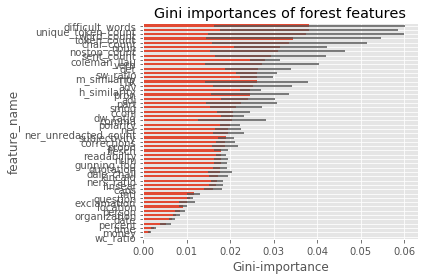

In [8]:
# Features by Gini Importance
X = training_set[predictors]
y = training_set['target_score'].astype(np.float64)

forest = ExtraTreesClassifier(n_estimators=25, random_state=26)
forest.fit(X, y)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

features = pd.DataFrame({'feature_name': X.columns, 'importance': forest.feature_importances_, 'std': std})
features.sort_values('importance')\
        .plot.barh(x='feature_name', y='importance', xerr='std', legend=False)
plt.title('Gini importances of forest features')
plt.xlabel('Gini-importance')
plt.tight_layout()
plt.show()

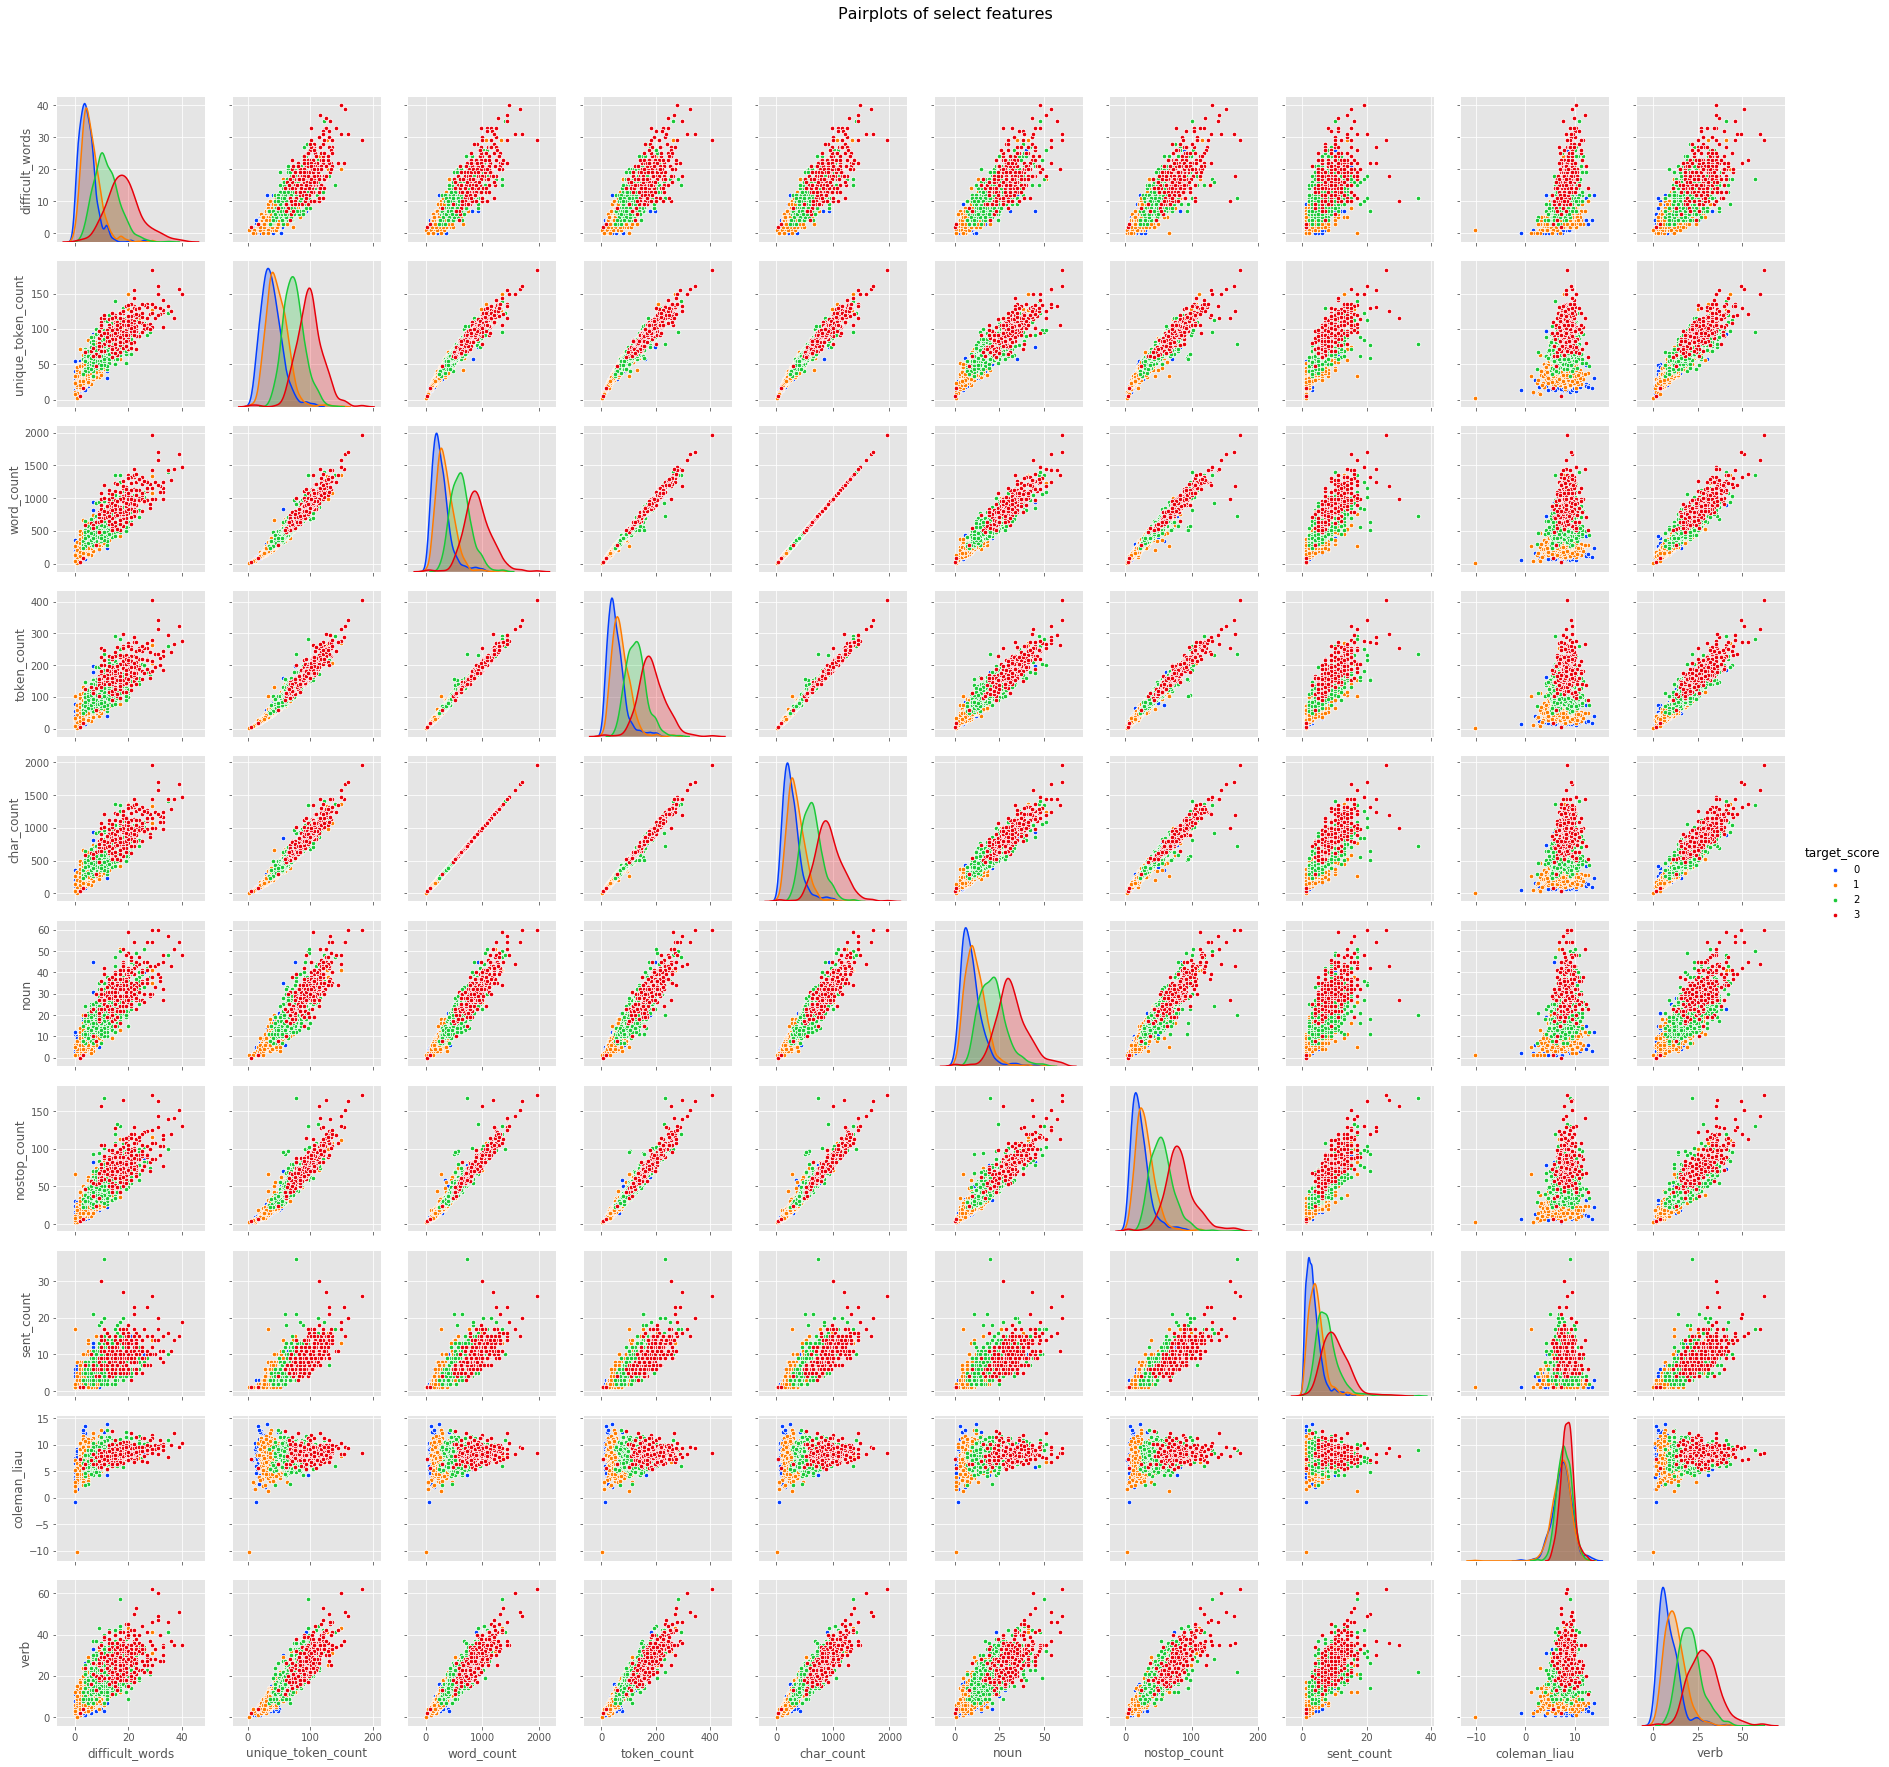

In [14]:
# Correlation Plots of Most Important Features
# usecols = ['word_count', 'token_count', 'unique_token_count', 'nostop_count', 'sent_count']
k = 5
usecols = features.sort_values('importance', ascending=False)['feature_name'].tolist()[:k]
g = sns.pairplot(training_set[training_set.topic == 4], hue='target_score', vars=usecols, plot_kws={"s": 20}, palette="bright")
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Pairplots of select features', fontsize=16)
plt.show()

In [ ]:
df = pd.DataFrame()

# Create and fit selector
selector = SelectKBest(f_regression, k=10) # f_classif, chi2, f_regression, mutual_info_classif, mutual_info_regression
for topic in range(1, 9):
    kpredictors = []
    
    # test for division by zero errors due to insufficient data:
    for p in predictors:
        if np.std(training_set[training_set.topic == topic][p], axis=0) != 0:
            kpredictors.append(p)
            
    # select k best for each topic:
    X = training_set[training_set.topic == topic][kpredictors]
    y = training_set[training_set.topic == topic].target_score
    selector.fit(X, y)

    # Get idxs of columns to keep
    mask = selector.get_support(indices=True)

    selected_features = training_set[training_set.topic == topic][predictors].columns[mask]
    df["Topic " + str(topic)] = selected_features

TypeError: ignored

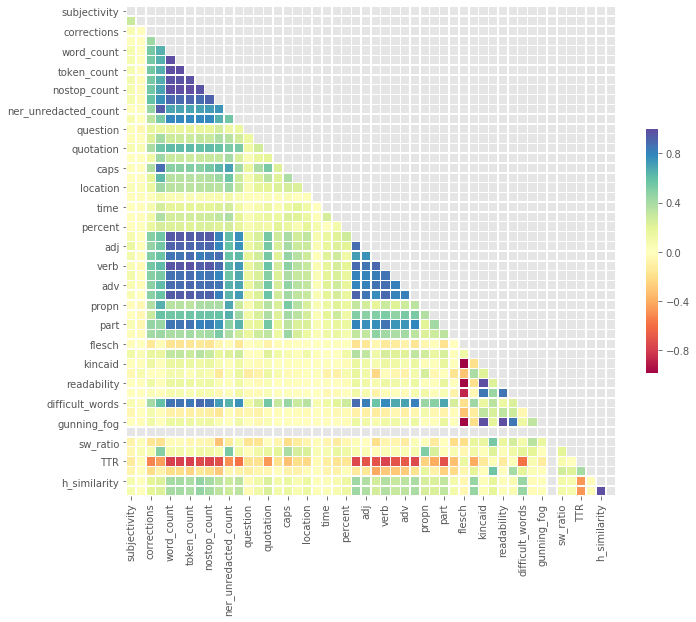

In [15]:
# Correlations of ALL Features
corr = training_set[predictors].corr() # default: Pearson
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
g = sns.heatmap(corr, mask=mask, cmap='Spectral', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Exporting .pkl File

In [120]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 86 columns):
essay_id                12976 non-null int64
topic                   12976 non-null int64
essay                   12976 non-null object
rater1_domain1          12976 non-null int64
rater2_domain1          12976 non-null int64
rater3_domain1          128 non-null float64
target_score            12976 non-null int64
rater1_domain2          1800 non-null float64
rater2_domain2          1800 non-null float64
topic2_target           1800 non-null float64
rater1_trait1           2292 non-null float64
rater1_trait2           2292 non-null float64
rater1_trait3           2292 non-null float64
rater1_trait4           2292 non-null float64
rater1_trait5           723 non-null float64
rater1_trait6           723 non-null float64
rater2_trait1           2292 non-null float64
rater2_trait2           2292 non-null float64
rater2_trait3           2292 non-null float64
rater2_trait4           2

In [7]:
# Only num64 or float objects can be exported
predictors = [  
    # 'essay_id',
    # 'topic',
    # 'essay',
    # 'target_score',
    # 'rater1_domain1',
    # 'rater2_domain1',

    'subjectivity',
    'polarity',
    # 'matches',
    'corrections',
    # 'corrected',
    # 'tokens',
    # 'lemma',
    # 'pos',
    # 'sents',
    'ner',
    'word_count',
    'char_count',
    'token_count',
    'unique_token_count',
    'nostop_count',
    'sent_count',
    'ner_unredacted_count',
    'comma',
    'question',
    'exclamation',
    'quotation',
    'organization',
    'caps',
    'person',
    'location',
    'money',
    'time',
    'date',
    'percent',
    'noun',
    'adj',
    'pron',
    'verb',
    'cconj',
    'adv',
    'det',
    'propn',
    'num',
    'part',
    'intj',
    'flesch',
    'smog',
    'kincaid',
    'coleman_liau',
    'readability',
    'dale_chall',
    'difficult_words',
    'linsear',
    'gunning_fog',
    # 'grade_level',
    'wc_ratio',
    'sw_ratio',
    'ners_ratio',
    'TTR',
    'dw_ratio',
    'h_similarity',
    'm_similarity',
    # 'l_essay',
]

In [132]:
training_set[predictors].to_pickle('data/preprocessedSupervised.pkl')